## Import Data

In [1]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
import pickle
from sklearn.utils import resample
import matplotlib as plt
from matplotlib.pyplot import hist

In [4]:
notes_database = pd.read_csv("/home/sanjaycollege15/ekg_notes.csv")

In [5]:
notes_database.head()

,SUBJECT_ID,ICD9_CODE,TEXT
0,87424,4019,Sinus rhythm with 2:1 A-V block. Right bundle...
1,14211,4019,Sinus tachycardia\nConsider old septal myocard...
2,88174,4019,Sinus rhythm. Low limb lead voltage. Compare...
3,30927,4019,Sinus rhythm. Early precordial QRS transition...
4,30927,4019,Sinus rhythm. Early precordial QRS transition...


---

## Pre-process Text

### Convert ICD9_CODE to 0-5

In [6]:
notes_database['ICD9_CODE']=notes_database['ICD9_CODE'].map({4019: 0, 4280: 1, 41401: 2,  42731: 3})

### Drop Duplicates

In [7]:
before = len(notes_database)
notes_database.drop_duplicates(inplace=True)
print(f"{before-len(notes_database)} rows removed. {len(notes_database)} rows remain.")


293583 rows removed. 363460 rows remain.


### Drop duplicate subjects

Subjects can be classified in two different categories with very similar notes. We drop duplicate subjects to mitigate this effect.

In [8]:
before = len(notes_database)
notes_database.drop_duplicates(subset='SUBJECT_ID', inplace=True)
print(f"{before-len(notes_database)} rows removed. {len(notes_database)} rows remain.")

337966 rows removed. 25494 rows remain.


In [9]:
notes_database.drop(columns="SUBJECT_ID", inplace=True)

### Balance the Dataset

Now that we've dropped duplicate subjects, we have a very imbalanced dataset. We'll downsample the more common values in order to get a more balanced dataset. 

In [10]:
notes_database['ICD9_CODE'].value_counts()

0    16518
1     5183
2     2159
3     1634
Name: ICD9_CODE, dtype: int64

In [11]:
df_4019_downsampled = resample(notes_database[notes_database.ICD9_CODE == 0], 
                                 replace=False,    
                                 n_samples=1634,     
                                 random_state=123)

df_4280_downsampled = resample(notes_database[notes_database.ICD9_CODE == 1], 
                                 replace=False,    
                                 n_samples=1634,     
                                 random_state=123)

df_41401_downsampled = resample(notes_database[notes_database.ICD9_CODE == 2], 
                                 replace=False,    
                                 n_samples=1634,     
                                 random_state=123)

df_downsampled = pd.concat([df_4019_downsampled, 
                            df_4280_downsampled, 
                            df_41401_downsampled, 
                            notes_database[notes_database.ICD9_CODE == 3]],
                            ignore_index=True)


In [12]:
df_downsampled['ICD9_CODE'].value_counts()

0    1634
1    1634
2    1634
3    1634
Name: ICD9_CODE, dtype: int64

In [13]:
notes_database = df_downsampled

### Lowercase text

In [14]:
notes_database['lower_text']=notes_database.TEXT.str.lower()

In [15]:
notes_database.drop(columns='TEXT', inplace=True)

### Remove Identifiers

Privacy identifiers are in the form [\*\*2157-1-7\*\*], as shown in the example below. We can remove them with a simple regex.

In [16]:
notes_database.lower_text[0]

'sinus rhythm.  compared to tracing #1 no diagnostic interim change.\ntracing #2\n\n'

In [17]:
notes_database.lower_text.replace('(\[\*\*)(.*)(\*\*\])', '', regex=True)[0]

'sinus rhythm.  compared to tracing #1 no diagnostic interim change.\ntracing #2\n\n'

In [18]:
notes_database['removedIdentifiers']=notes_database.lower_text.replace('(\[\*\*)(.*)(\*\*\])', '', regex=True)

In [19]:
notes_database.drop(columns="lower_text", inplace=True)

In [20]:
notes_database.to_pickle('/home/sanjaycollege15/PredictingDiagnoses/Data/intermediate_ekg.pkl')

### Dropping stop words

Did not end up dropping stop words because they seemed important in interpreting the notes. Unlike sentiment analysis, negations like "not" or "nor" could be important in clinical notes. The models I'm going to be using will need to leverage the context from stop words.

In [13]:
# nltk.download('stopwords')
# stop_words = stopwords.words('english')

In [14]:
#notes_database['notes_without_stopwords'] = notes_database['removedIdentifiers'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [15]:
#notes_database.notes_without_stopwords[0]

### Noise removal, sentence splitting

Removed most punctuation, but leaving in '-' and ':' since they're commonly used medical terms.

In [21]:
notes_database['removedIdentifiers'][0]

'sinus rhythm.  compared to tracing #1 no diagnostic interim change.\ntracing #2\n\n'

In [22]:
tokenizer = Tokenizer(
    #num_words = 150,
    filters='!"#$%&()*+/<=>@[\\]^_`{|}~\t\n',
    split = ' ', 
    char_level = False)

In [23]:
tokenizer.fit_on_texts(notes_database['removedIdentifiers'])

In [24]:
sequences = tokenizer.texts_to_sequences(notes_database['removedIdentifiers'])


In [25]:
denoised_sentences = []

for i in sequences:
    denoised_sentences.append(' '.join(tokenizer.index_word[w] for w in i))

### Paddings

In [33]:
lengths = []
for i in denoised_sentences:
    lengths.append(len(i))
    
print(f"Average sentence length: {sum(lengths)/len(lengths)}")
print(f"Max sentence length: {max(lengths)}")
print(f"Min sentence length: {min(lengths)}")

Average sentence length: 201.8235924112607
Max sentence length: 832
Min sentence length: 0


(array([4.150e+02, 2.320e+03, 2.099e+03, 1.042e+03, 4.320e+02, 1.660e+02,
        4.500e+01, 9.000e+00, 6.000e+00, 2.000e+00]),
 array([  0. ,  83.2, 166.4, 249.6, 332.8, 416. , 499.2, 582.4, 665.6,
        748.8, 832. ]),
 <BarContainer object of 10 artists>)

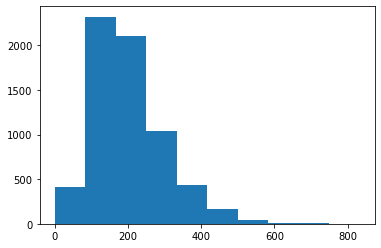

In [38]:
hist(lengths)

In [62]:
with open("/home/sanjaycollege15/PredictingDiagnoses/Data/denoised_sentences.txt", "wb") as fp:
    pickle.dump(denoised_sentences, fp)

Switch to Preprocess Text - Notebook 2 in order to continue constructing the dataframe. Ran out of memory in this notebook.

---

### Tokenize into Sentences

In [65]:
tokenized_sentences = []

for i in denoised_sentences:
    tokenized_sentences.append(sent_tokenize(i))

In [66]:
with open("/home/sanjaycollege15/PredictingDiagnoses/Data/tokenized_sentences.txt", "wb") as fp:
    pickle.dump(tokenized_sentences, fp)

Switch to Preprocess Text - Notebook 2 in order to continue constructing the dataframe. Ran out of memory in this notebook.

### Stemming